<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/experiment/c620_wgan_create_fake_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset,DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from torch.nn import functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import warnings
import joblib
warnings.simplefilter('ignore')

# LOAD DATA

In [3]:
df_url = '/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c620_data.xlsx'
c_url = '/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl'
c = joblib.load(c_url)
df = pd.read_excel(df_url,index_col=0)
df.head()

,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Compositio

In [4]:
x_col = c['x41']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
op_col = df[op_col].dropna(axis=1).columns.tolist()
print(len(x_col),len(op_col))

41 8


In [5]:
dataset = TensorDataset(torch.FloatTensor(df[x_col+op_col].values))
data_iter = DataLoader(dataset,batch_size=64,drop_last=True)
next(iter(data_iter))[0].shape

torch.Size([64, 49])

# model and optimizer

# wgan
* 1.判别器最后一层去掉sigmoid
* 2.生成器和判别器的loss不取log
* 3.每次更新判别器的参数之后把它们的绝对值截断到不超过一个固定常数c
* 4.不要用基于动量的优化算法（包括momentum和Adam），推荐RMSProp，SGD也行

In [6]:
latent_dim = 128
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.f1 = nn.Linear(latent_dim,latent_dim)
    self.f2 = nn.Linear(latent_dim,latent_dim)
    self.wt_head = nn.Linear(latent_dim,len(x_col))
    self.op_head = nn.Linear(latent_dim,len(op_col))
  def forward(self, z):
    z = F.relu(self.f1(z))
    z = F.relu(self.f2(z))
    wt = F.sigmoid(self.wt_head(z))
    wt = wt / wt.sum(dim=1).reshape(-1,1)
    wt = wt * 100
    op = self.op_head(z)
    return torch.cat((wt,op),dim=1)

In [7]:
generator = Generator()
discriminator = nn.Sequential(nn.Linear(len(x_col)+len(op_col),1))
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=0.00005)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=0.00005)

In [11]:
def train(generator,discriminator,optimizer_D,optimizer_G,data_iter,num_epoch=30000,n_critic=5,clip_value=0.01,latent_dim=128):
  batches_done = 0
  history = {'loss_G':[],'loss_D':[]}
  for epoch in range(num_epoch):
    for i, datas in enumerate(data_iter):
      datas = datas[0]
      real_datas = Variable(datas.type(torch.FloatTensor))
      # ---------------------
      #  Train Discriminator
      # ---------------------
      optimizer_D.zero_grad()
      # Sample noise as generator input
      z = Variable(torch.FloatTensor(np.random.normal(0,1,(real_datas.shape[0],latent_dim))))
      # Generate a batch of datas
      fake_datas = generator(z).detach()
      # Adversarial loss
      assert real_datas.shape == fake_datas.shape
      loss_D = -torch.mean(discriminator(real_datas)) + torch.mean(discriminator(fake_datas))
      loss_D.backward()
      optimizer_D.step()
      # Clip weights of discriminator
      for p in discriminator.parameters():
        p.data.clamp_(-clip_value,clip_value)
      # Train the generator every n_critic iterations
      if i % n_critic == 0:
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        # Generate a batch of datas
        gen_datas = generator(z)
        # Adversarial loss
        loss_G = -torch.mean(discriminator(gen_datas))
        loss_G.backward()
        optimizer_G.step()
        history['loss_G'].append(loss_G.item())
        history['loss_D'].append(loss_D.item())
        if epoch % 100 == 0:
          print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% 
                (epoch,num_epoch,batches_done%len(data_iter),len(data_iter),loss_D.item(),loss_G.item()))
      batches_done += 1
  return generator.eval(),discriminator.eval(),history

In [12]:
generator,discriminator,history = train(generator,discriminator,optimizer_D,optimizer_G,data_iter)

[Epoch 0/30000] [Batch 0/2] [D loss: -5.667407] [G loss: -0.001796]
[Epoch 100/30000] [Batch 0/2] [D loss: -4.952071] [G loss: 0.442955]
[Epoch 200/30000] [Batch 0/2] [D loss: -5.709550] [G loss: 0.407857]
[Epoch 300/30000] [Batch 0/2] [D loss: -5.352916] [G loss: 0.092537]
[Epoch 400/30000] [Batch 0/2] [D loss: -5.066171] [G loss: 0.045742]
[Epoch 500/30000] [Batch 0/2] [D loss: -4.954909] [G loss: -0.013426]
[Epoch 600/30000] [Batch 0/2] [D loss: -4.805312] [G loss: -0.186056]
[Epoch 700/30000] [Batch 0/2] [D loss: -4.628430] [G loss: -0.141163]
[Epoch 800/30000] [Batch 0/2] [D loss: -4.580403] [G loss: 0.086190]
[Epoch 900/30000] [Batch 0/2] [D loss: -4.532226] [G loss: -0.013327]
[Epoch 1000/30000] [Batch 0/2] [D loss: -4.432313] [G loss: -0.128166]
[Epoch 1100/30000] [Batch 0/2] [D loss: -4.315238] [G loss: -0.235507]
[Epoch 1200/30000] [Batch 0/2] [D loss: -4.115944] [G loss: -0.475288]
[Epoch 1300/30000] [Batch 0/2] [D loss: -3.667544] [G loss: -0.913688]
[Epoch 1400/30000] [Bat

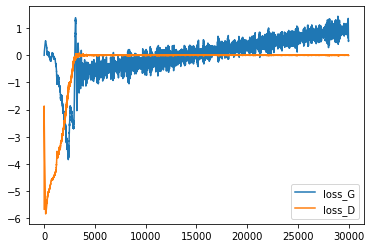

In [13]:
plt.plot(history['loss_G'],label='loss_G')
plt.plot(history['loss_D'],label='loss_D')
plt.legend()
plt.show()

In [15]:
z = Variable(torch.FloatTensor(np.random.normal(0,1,(9999,latent_dim))))
fake_data = generator(z)

In [16]:
fake_data.detach().numpy()[:,:41].sum(axis=1)

array([100.      ,  99.999985, 100.      , ..., 100.000015, 100.000015,
        99.999985], dtype=float32)

In [17]:
fake_data = pd.DataFrame(fake_data.detach().numpy(),columns=x_col+op_col)
fake_data

,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
0,2.054447e-17,0.011988,0.418850,0.361937,0.043467,0.073527,0.008266,20.689224,1.267521e-15,9.915550e-15,4.933581e-21,5.263561e-14,40.789558,2.901061e-17,3.746477e-13,0.012450,0.634005,6.723763,10.071969,6.717552,0.006048,1.019251e-16,9.115145e-14,4.133491e-17,0.691996,0.266682,2.238899,0.105116,7.364310,1.287985e-19,0.77824

In [18]:
fake_data.to_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/fake_data/c620_fake_data.csv')